In [6]:
#Imports
import numpy as np

import h5py

import h5flow
from h5flow.data import dereference

import matplotlib.pyplot as plt
import mplhep as hep

from datetime import date

import glob
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA

from scipy.spatial.distance import cdist

flist = glob.glob('/global/cfs/cdirs/dune/users/demaross/MiniRun5_files_without_MEVR/*.hdf5')

f_manager1 = h5flow.data.H5FlowDataManager(flist, 'r')
print(len(flist))
#Detector boundaries
x_boundaries = np.array([-63.931, -3.069, 3.069, 63.931])
y_boundaries = np.array([-42-19.8543, -42+103.8543]) 
z_boundaries = np.array([-64.3163,  -2.6837, 2.6837, 64.3163])

883


# Truth backtracking

In [7]:
import numpy as np
import h5flow  # Ensure h5flow is correctly installed and imported

def back_track_hits(files, hits_dset_name):
    trajs_of_selection = []
    segs_of_selection = []
    
    for file in files:
        try:
            # Load data sets
            f = h5flow.data.H5FlowDataManager(file, 'r')

            segments = f['mc_truth/segments/data']
            trajectories = f['mc_truth/trajectories/data']
            dset_hits = f['charge/'+hits_dset_name+'/data']

            track2hits = dereference(
                f['/analysis/rock_muon_tracks/data']['rock_muon_id'],     # indices of A to load references for, shape: (n,)
                f['/analysis/rock_muon_tracks/ref/charge/calib_prompt_hits/ref'],  # references to use, shape: (L,)
                f['/charge/calib_prompt_hits/data'],
                ref_direction=(0,1)  # dataset to load, shape: (M,)
            )

            # Loop through the tracks
            for hits_of_track in track2hits:
                trajs_of_track = []
                hits = np.array([tup for tup in hits_of_track.data if not all(np.all(elem == 0) for elem in tup)], dtype=hits_of_track.dtype)

                total_charge = np.sum(hits['Q'])
                total_energy = np.sum(hits['E'])

                hit_ref = hits['id']
                hits_bt = f['mc_truth/'+hits_dset_name[:-1]+'_backtrack/data'][hit_ref] 

                # Check if hit['id'] matches index in dset_hits_name
                indices = np.where(np.isin(dset_hits['id'], hits['id']))[0]

                for i in range(len(indices)):
                    if indices[i] != hits['id'][i]:
                        print(f'WARNING: rock_muon hit id not the same as {hits_dset_name} index')

                # Plot all of the backtracked segment positions
                for hit in hits_bt:
                    for cont in range(len(hit['fraction'])):
                        if hit['fraction'][cont] > 0.0001:
                            seg_id = hit['segment_ids'][cont]
                            seg = segments[seg_id]
                            
                            # Append trajectory information to the list
                            trajs_of_track.append([
                                seg['file_traj_id'],  # File trajectory ID
                                seg['n_electrons'],  # Number of electrons
                                hit['fraction'][cont],  # Fraction associated with the hit
                                seg_id
                            ])

                            if not seg['segment_id'] == seg_id:
                                print(f'WARNING: segment id not the same as segment index!')

                traj_arr = np.array(trajs_of_track)
                unique_trajs = np.unique(traj_arr[:, 0])

                traj_ratios = []

                for traj in unique_trajs:
                    mask = traj_arr[:, 0] == traj
                    trajects = traj_arr[mask]
                    Q_contribution = np.sum(trajects[:, 1] * trajects[:, 2])
                    ratio = Q_contribution / total_charge
                    traj_ratios.append([ratio, traj])

                # Convert traj_ratios to a numpy array for easy indexing
                traj_ratios = np.array(traj_ratios)

                if len(traj_ratios) > 0:
                    index = np.argmax(traj_ratios[:, 0])
                    leading_traj = traj_ratios[index][1]
                    
                    index_traj = np.where(trajectories['file_traj_id'] == leading_traj)[0]
                    leading_traj_info = trajectories[index_traj]

                    trajs_of_selection.append(leading_traj_info)

                    # Grab segments that make up the leading trajectory of the rock muon track
                    mask = traj_arr[:, 0] == leading_traj
                    segment_ids = traj_arr[mask][:, 3]
                    indices = np.where(np.isin(segments['segment_id'], segment_ids))[0]

                    segs_of_track = segments[indices]
                    segs_of_selection.append(segs_of_track)

        except Exception as e:
            print(f'Error processing file {file}: {e}')
    
    return np.concatenate(trajs_of_selection), np.concatenate(segs_of_selection)

   

#Purity and efficiency

def is_point_outside(point, x_boundaries, y_boundaries, z_boundaries):

    x, y, z = point[0], point[1], point[2]
    
    xmin, xmax, ymin, ymax, zmin, zmax = x_boundaries.min(), x_boundaries.max(), y_boundaries.min(), y_boundaries.max(), z_boundaries.min(), z_boundaries.max()
    
    return x < xmin or x > xmax or y < ymin or y > ymax or z < zmin or z > zmax
    
def detector_eff(filelist):
    
    A = 'mc_truth/interactions'
    B = 'mc_truth/segments'
    C= 'charge/packets'
    D = 'charge/calib_prompt_hits'

    counts_of_true_rock_muons = 0
    
    n_rock_tracks = []
    
    for file in filelist:
        f = h5flow.data.H5FlowDataManager(file, 'r')

        interactions = f['mc_truth/interactions/data']
        trajs = f['mc_truth/trajectories/data']
        rock_tracks = f['analysis/rock_muon_tracks/data']
        tracks = np.unique(rock_tracks['rock_muon_id'])

        n_rock_tracks.append(len(tracks))
        
        for index, interaction in enumerate(interactions):

            vertex = np.column_stack((interaction['x_vert'], interaction['y_vert'], interaction['z_vert']))[0]
           
            pdg = interaction['lep_pdg']
            nu_pdg = interaction['nu_pdg']
            
            event = int(str(interaction['event_id'])[3:])
            #print(index)
            #PromptHits_ev = f["charge/events", "charge/calib_prompt_hits", event]
            
            if  is_point_outside(vertex, x_boundaries, y_boundaries, z_boundaries) & (pdg == 13 or pdg == -13) & (nu_pdg == 14 or nu_pdg == -14):
                a2b_ref = dereference(
                index,     # indices of A to load references for, shape: (n,)
                f['/{}/ref/{}/ref'.format(A,B)],  # references to use, shape: (L,)
                f['/{}/data'.format(B)],       # dataset to load, shape: (M,)
                region = f['/{}/ref/{}/ref_region'.format(A,B)], # lookup regions in references, shape: (N,)
                indices_only = True,
                ref_direction = (0,1)
                )

            b2c = dereference(
                a2b_ref.ravel(),     # indices of A to load references for, shape: (n,)
                f['/{}/ref/{}/ref'.format(C,B)],  # references to use, shape: (L,)
                f['/{}/data'.format(C)], # dataset to load, shape: (M,) # lookup regions in references, shape: (N,)
                ref_direction = (0,1),
                indices_only = True
                )


            c2d = dereference(
                np.unique(b2c.ravel()),     # indices of A to load references for, shape: (n,)
                f['/{}/ref/{}/ref'.format(D,C)],  # references to use, shape: (L,)
                f['/{}/data'.format(D)], # dataset to load, shape: (M,) # lookup regions in references, shape: (N,)
                ref_direction = (0,1),
                indices_only = True
                )
            
            indices = np.sort([int(x) for x in c2d.ravel() if x != '--'])

            dset_shape= f['charge/calib_prompt_hits/data'].shape

            valid_indices = np.sort([index for index in indices if 0 <= index < dset_shape[0]])

            try:
                hits_of_interaction = f['charge/calib_prompt_hits/data'][valid_indices]
                # Check the length of the extracted data
                if len(hits_of_interaction) >= 100:
                    counts_of_true_rock_muons += 1
            except Exception as e:
                print({e}, indices, f['charge/calib_prompt_hits/data'].shape)
     
    return sum(n_rock_tracks)/np.array([counts_of_true_rock_muons])[0]

def amount_of_particle(pdg, trajs):
    
    mask = trajs['pdg_id'] == pdg
    
    trajs_with_pdg = trajs[mask]
    
    amount = len(trajs_with_pdg)
    
    percent = round((amount/len(trajs)) * 100, 2)
    
    return amount, percent

In [ ]:
data_set = 'calib_prompt_hits'
# demonstration of generic backtracking
all_leading_trajs, all_segs = back_track_hits(f_manager1.filepath, data_set)
eff = detector_eff(f_manager1.filepath)
print(eff)
np.save('/global/homes/d/demaross/MR5graphs/true_rock_muon_segs_{}_{}_{}.npy'.format('noMEVR',data_set,date.today()), all_segs)
np.save('/global/homes/d/demaross/MR5graphs/true_rock_muon_trajs_{}_{}_{}.npy'.format('noMEVR',data_set,date.today()), all_leading_trajs)

In [9]:
type_of_particles = {
    "d": 1,
    "u": 2,
    "s": 3,
    "c": 4,
    "b": 5,
    "t": 6,
    "$e^-$": 11,
    "$e^+$": -11,
    "$\\nu_e$": 12,
    "$\\mu^-$": 13,
    "$\\mu^+$": -13,
    "$\\nu_\\mu$": 14,
    "$\\tau^-$": 15,
    "$\\nu_\\tau$": 16,
    "$\\tau'^-$": 17,
    "$\\nu_\\tau'$": 18,
    "$e^{*^-}$": 4000011,
    "$\\nu_e^*$": 4000012,
    "$\\mu^{*^-}$": 4000013,
    "$\\nu_\\mu^*$": 4000014,
    "$\\tau^{*^-}$": 4000015,
    "$\\nu_\\tau^*$": 4000016,
    "$g$": 21,
    "$\\pi^{+}$": 211,   # Pion Positive
    "$\\pi^{-}$": -211,  # Pion Negative
    "$\\pi^0$": 111,     # Pion Neutral
    "$p^+$": 2212,       # Proton
    "$K^+$": 321,        # Kaon Positive
    "$K^-$": -321,       # Kaon Negative
    "$K^0$": 311,        # Kaon Neutral
    "$\\bar{K}^0$": -311  # Kaon Anti-Neutral
}


In [10]:
particles = {}

percentages = [] 

unique_pdgs = np.unique(all_leading_trajs['pdg_id'])

for pdg in unique_pdgs:
    if pdg in type_of_particles.values():
        index = np.where(list(type_of_particles.values()) == pdg)[0][0]
        
        particle = list(type_of_particles.keys())[index]
        
        #Get amount of this particle
        amount, percent = amount_of_particle(pdg, all_leading_trajs)
        
        particles.update({particle : amount})
        percentages.append(percent)
        
    else:
        particle = '{}'.format(pdg)
        #Get amount of this particle
        amount, percent = amount_of_particle(pdg, all_leading_trajs)
        
        particles.update({particle : amount})
        percentages.append(percent)
        
    
#Get purity

mask = (all_leading_trajs['pdg_id'] == -13) | (all_leading_trajs['pdg_id'] == 13)

muons = all_leading_trajs[mask]

purity = round(len(muons)/len(all_leading_trajs) * 100,2)

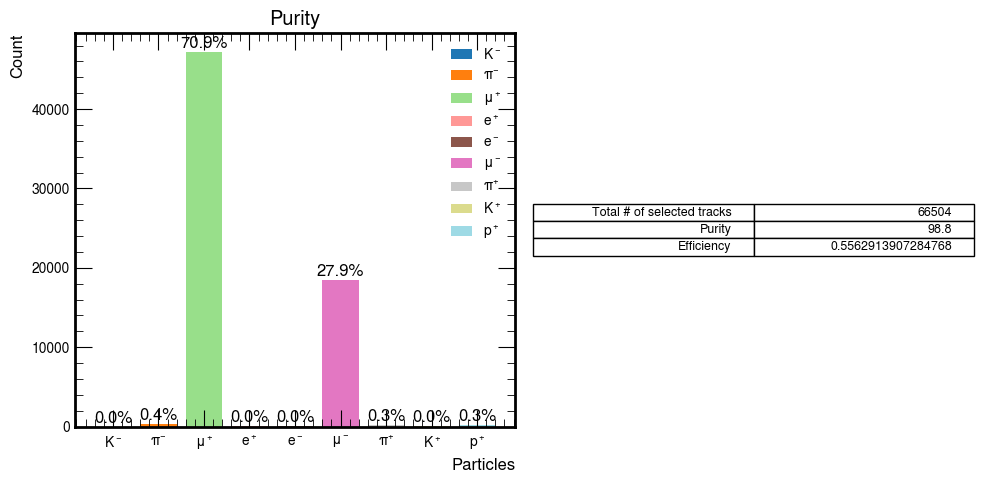

In [11]:
plt.style.use(hep.style.CMS)

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))

# Convert keys and values to lists for indexing
particle_list = list(particles.keys())
count_list = list(particles.values())

# Calculate percentages
total_count = sum(count_list)
percentages = [f'{(count / total_count) * 100:.1f}%' for count in count_list]

x = np.arange(len(particles))  # the label locations

# Define colormap
colormap = plt.get_cmap('tab20') 
colors = colormap(np.linspace(0, 1, len(particles)))

# Plot the bars and store references
bars = ax[0].bar(x, count_list, color = colors , tick_label=particle_list, label=particle_list)

# Loop through bars and add percentages
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    ax[0].text(
        bar.get_x() + bar.get_width() / 2, 
        height,  # Position the text slightly above the bar
        percentage,
        ha='center', 
        va='bottom'
    )

# Customize the plot
ax[0].set_xlabel('Particles')
ax[0].set_ylabel('Count')
ax[0].set_title('Purity')
ax[0].legend()


table_data = [['Total # of selected tracks', len(all_leading_trajs)],['Purity',purity],['Efficiency', eff]]
ax[1].table(cellText=table_data, loc='center', fontsize = 8)
ax[1].axis('off')  # Hide axis
fig.tight_layout()
fig.show()

fig.savefig('/global/cfs/cdirs/dune/users/demaross/MR5graphs/purityplot_noMEVR_min1_eps8_{}_{}'.format(data_set, date.today()))